In [1]:
import numpy as np

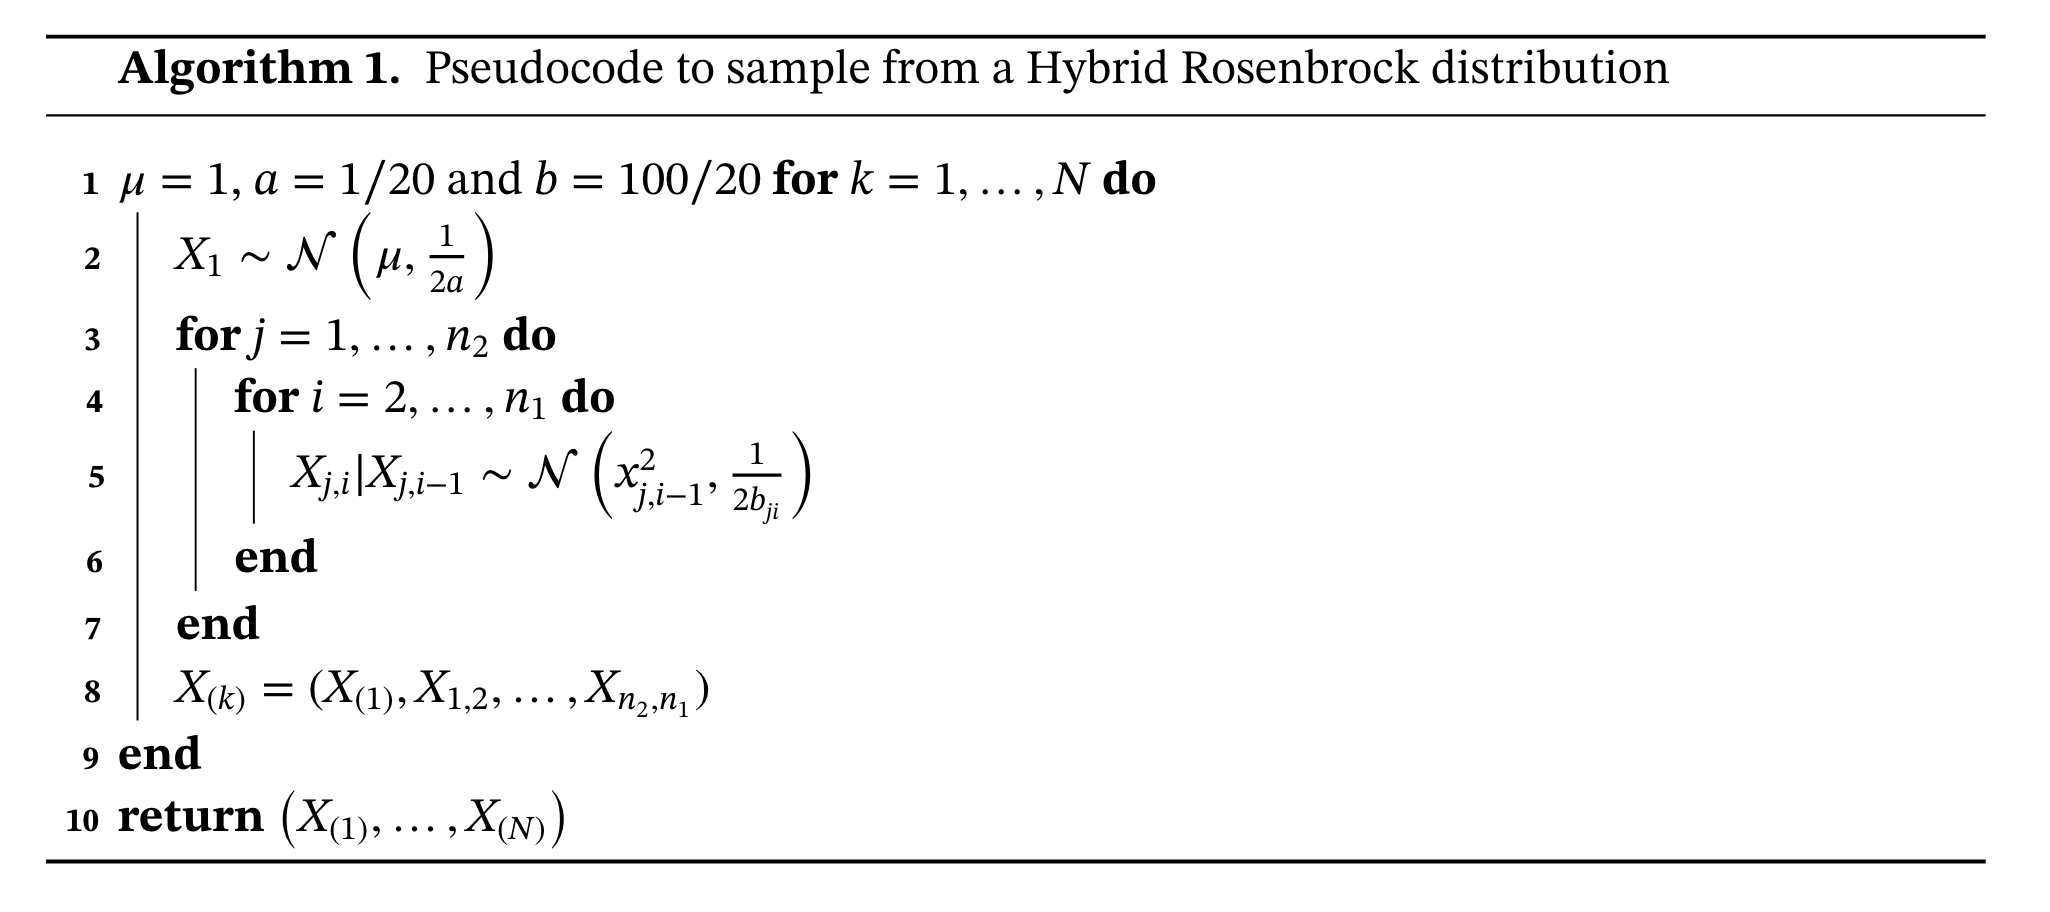


In [26]:
n1 = 3  # block size
n2 = 2  # number of blocks

for j in range(n2):
    for i in range(1, n1):
        print(i, j, (n1-1) * j + i)

1 0 1
2 0 2
1 1 3
2 1 4


In [ ]:
def sample_rosenbrock(n_iter, n1, n2, mu=1, a=0.05, b=5):
    n_dim = (n1 - 1) * n2 + 1

    X = np.empty((n_dim, n_iter))

    for t in range(n_iter):
        X[0, t] = np.random.normal(mu, 1/np.sqrt(2*a))

        for j in range(n2):
            for i in range(1, n1):
                idx = (n1-1) * j + i

                if i == 1:
                    x_parent = X[0, t]
                else:
                    x_parent = X[idx-1, t]

                X[idx, t] = np.random.normal(x_parent**2, 1/np.sqrt(2*b))
    
    return X

In [21]:
samples = sample_rosenbrock(1000, 3, 2)
samples.shape

(5, 1000)

$$\pi(\mathbf{x}) \propto \exp \left\{ -a\left(x_1 - \mu\right)^2 - b_{1, 2}\left(x_{1, 2} - x_1^2\right)^2 \right\}$$

Standard parametrization:

-   $\mu = 1$
-   $a  = 1/20$
-   $b_{i, j} = 100/20 \quad (\forall i, j)$


$$\log\pi(\mathbf{x}) \propto - a \left(x_1 - \mu\right)^2 - b_{1, 2} \left(x_{1, 2} - x_1^2\right)^2$$


In [ ]:
def logpi_rosenbrock(x, n1, n2, mu=1, a=0.05, b=5):
    logpi = - a * (x[0] - mu)**2

    for j in range(n2):
        for i in range(1, n1):
            idx = (n1-1) * j + i

            if i == 1:
                x_parent = x[0]
            else:
                x_parent = x[idx-1]
            
            logpi += - b * (x[idx] - x_parent**2)**2

    return logpi

$$
\frac{\partial}{\partial x_{j,i}}\log\pi(\mathbf{x})
=
\begin{cases}
-\,2\,a\,\bigl(x_1 - \mu\bigr)
  \;+\;\sum_{j=1}^{n_2} 4\,b_{j,2}\,\bigl(x_{j,2} - x_1^2\bigr)\,x_1
& \quad i = 1
\\[1.2em]
-2\,b_{j,i}\,\bigl(x_{j,i} - x_{j,i-1}^{2}\bigr)
   \;+\;
   4\,b_{j,i+1}\,\bigl(x_{j,i+1} - x_{j,i}^{2}\bigr)\,x_{j,i}
& \quad 2 \le i < n_1
\\[1.2em]
-2\,b_{j,n_{1}}\,
   \bigl(x_{j,n_{1}} - x_{j,n_{1}-1}^{2}\bigr)
& \quad i = n_1
\end{cases}
\quad
\text{for all } j = 1,\dots,n_{2}
$$


In [ ]:
def partial_logpi_rosenbrock(x, n1, n2, mu=1, a=0.05, b=5):
    partial_logpi = np.empty_like(x)

    partial_logpi[0] = - 2 * a * (x[0] - mu)
    for j in range(n2):
        partial_logpi[0] += 4 * b * (x[(n1-1)*j+1] - x[0]**2) * x[0]

    for j in range(n2):
        for i in range(1, n1-1):
            idx = (n1-1) * j + i

            if i == 1:
                x_parent = x[0]
            else:
                x_parent = x[idx-1]
            
            x_child = x[idx+1]

            partial_logpi[idx] = - 2 * b * (x[idx] - x_parent**2) + 4 * b * (x_child - x[idx]**2) * x[idx]
        
        # i = n1
        idx = (n1-1) * (j+1)  # (n1-1) * j + (n1-1)
        partial_logpi[idx] = - 2 * b * (x[idx] - x[idx-1]**2)
    
    return partial_logpi

$$
\begin{aligned}
%------------------------------------------------
% Second derivative wrt x_{j,i}^2
%------------------------------------------------
\frac{\partial^2}{\partial x_{j, i}^2}\,\log\pi(\mathbf{x})
&=
\begin{cases}
-\,2\,a
  \;+\;
  \displaystyle
  \sum_{j=1}^{n_{2}}
    4\,b_{j,2}\
      \Bigl(
         x_{j,2} \;-\; 3\,x_1^{2}
      \Bigr)
& \quad i = 1
\\[1.2em]
-\,2\,b_{j,i}
  \;+\;
  4\,b_{j,i+1}\
    \Bigl(
       x_{j,i+1} \;-\; 3\,x_{j,i}^{2}
    \Bigr)
& \quad 2 \le i < n_1
\\[1.2em]
-\,2\,b_{j,n_1}
& \quad i = n_1
\end{cases}
\\[1.2em]
%------------------------------------------------
% Cross partial derivative wrt x_{j,i} and x_{j,i'}
%------------------------------------------------
\frac{\partial^2}{\partial x_{j, i}\,\partial x_{j, i'}}\,\log\pi(\mathbf{x})
&=
\begin{cases}
4\,b_{j,i'}\,x_{j,i}
& \quad i' = i + 1
\\[1.2em]
0
& \quad \text{otherwise}
\end{cases}
\end{aligned}
$$


In [ ]:
def hessian_logpi_rosenbrock(x, n1, n2, mu=1, a=0.05, b=5):
    hessian_logpi = np.zeros((x.shape[0], x.shape[0]))

    hessian_logpi[0, 0] = - 2 * a
    for j in range(n2):
        hessian_logpi[0, 0] += 4 * b * (x[(n1-1)*j+1] - 3*(x[0]**2))
    
    for j in range(n2):
        for i in range(1, n1-1):
            idx = (n1-1) * j + i
            hessian_logpi[idx, idx] = - 2 * b + 4 * b * (x[idx+1] - 3*(x[idx]**2))
        
        idx = (n1-1) * (j+1)
        hessian_logpi[idx, idx] = - 2 * b
    
    for j in range(n2):
        for i in range(1, n1):
            idx = (n1-1) * j + i
            
            if i == 1:
                hessian_logpi[idx, 0] = 4 * b * x[0]
                hessian_logpi[0, idx] = hessian_logpi[idx, 0]
            else:
                hessian_logpi[idx, idx-1] = 4 * b * x[idx-1]
                hessian_logpi[idx-1, idx] = hessian_logpi[idx, idx-1]
    
    return hessian_logpi